In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
import glob
import anacal
import xlens
import fitsio
import lsst.afw.image as afwImage
import astropy.table as astTable
from astropy.visualization import ZScaleInterval
import fitsio

In [62]:
full = fitsio.read("tracts_fdfc_v1_final.fits")

In [63]:
len(full)

37057

In [38]:
full = fitsio.read("tracts_fdfc_v1_final.fits")
tract_list = np.unique(full["tract"])
corr_dir = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_noisecorr/"
for tract_id in [10065, 10190, 10423, 10661, 15993]:
    msk = (full["tract"] == tract_id)
    patch_list = full["patch"][msk]
    index_list = full["index"][msk]
    dd = np.zeros((49, 49)) 
    for patch_db, index in zip(patch_list, index_list):
        patch_x = patch_db // 100
        patch_y = patch_db % 100
        patch_id = patch_x + patch_y * 9
        fname = os.path.join(
            corr_dir, 
            f"{tract_id}/{patch_id}/noise_correlation.fits",
        )
        tmp = fitsio.read(fname)
        if not np.any(np.isnan(tmp)):
            dd = dd + tmp
        else:
            print(tract_id, patch_id, index)
    p = dd[24, 24]
    dd = dd / p
    if not np.max(dd) == 1:
        print(tract_id)

10065 31 28369
10190 40 32484
10423 5 33938
10661 16 34725
15993 38 36007


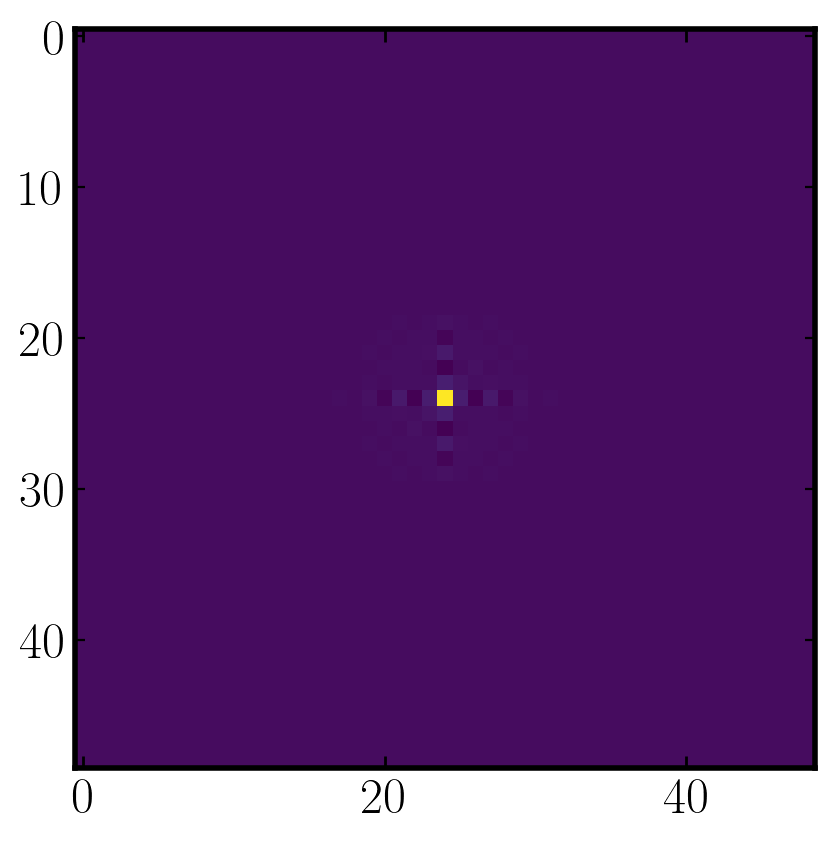

In [60]:
tract_id = tract_list[14]
fname = os.path.join(
    corr_dir, 
    f"{tract_id}.fits",
)
im = fitsio.read(fname)
plt.close()
plt.imshow(im)


In [61]:
im.max()

1.0

In [44]:
for entry in full:
    tract_id = entry["tract"]
    patch_db = entry["patch"]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    patch_id = patch_x + patch_y * 9
    tp = (tract_id * 100 + patch_id).astype(int)
    if tp in [1006531, 1019040, 1042305, 1066116, 1599338]:
        print(entry["index"])

28369
32484
33938
34725
36007


In [43]:
entry = full[28369]
tract_id = entry["tract"]
patch_dp = entry["patch"]
patch_x = patch_db // 100
patch_y = patch_db % 100
patch_id = patch_x + patch_y * 9
tp = (tract_id * 100 + patch_id).astype(int)
print(patch_id)
print(tp)

53
1006553


In [21]:
s23b_calexp = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_calexp/"
s23b_mask = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_mask/"
s23b_nimg = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_nImage/"
tract_id = 10065
patch_id = 31
calexp_dir = f"{s23b_calexp}/{tract_id}/{patch_id}/i"
exp_fname = glob.glob(os.path.join(calexp_dir, "*.fits"))[0]
exposure = afwImage.ExposureF.readFits(exp_fname)
mask_dir = f"{s23b_mask}/{tract_id}/{patch_id}"
mask_fname = os.path.join(mask_dir, "mask2.fits")
bmask = fitsio.read(mask_fname)
nim_dir = f"{s23b_nimg}/{tract_id}/{patch_id}/i"
nim_fname = glob.glob(os.path.join(nim_dir, "*.fits"))[0]
bmask = (bmask | (fitsio.read(nim_fname) <=2).astype(np.int16))

noise_array = np.asarray(
    exposure.image.array,
    dtype=np.float32,
)[500:3500, 500:3500]

window_array = np.asarray(
    (bmask == 0) & (exposure.mask.array == 0) &
    (exposure.image.array ** 2.0 < exposure.variance.array * 10),
    dtype=np.float32,
)[500:3500, 500:3500]
noise_array[~window_array.astype(bool)] = 0.0

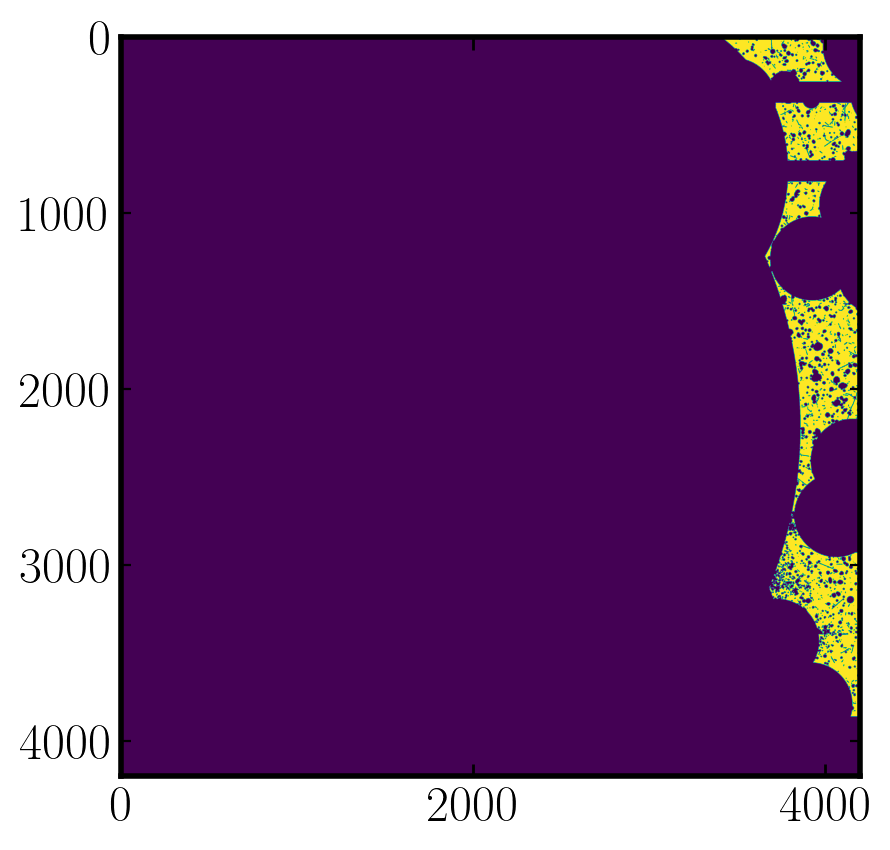

In [32]:
plt.imshow(((bmask == 0) & (exposure.mask.array == 0)).astype(int))

In [30]:
window_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
pad_width = ((10, 10), (10, 10))  # ((top, bottom), (left, right))
noise_array = np.pad(
    noise_array,
    pad_width=pad_width,
    mode="constant",
    constant_values=0.0,
)
window_array = np.pad(
    window_array,
    pad_width=pad_width,
    mode="constant",
    constant_values=0.0,
)

npix = 49
ny, nx = window_array.shape
npixl = int(npix // 2)
npixr = int(npix // 2 + 1)
noise_corr = np.fft.fftshift(
    np.fft.ifft2(np.abs(np.fft.fft2(noise_array)) ** 2.0)
).real[
    ny // 2 - npixl : ny // 2 + npixr, nx // 2 - npixl : nx // 2 + npixr
]
window_corr = np.fft.fftshift(
    np.fft.ifft2(np.abs(np.fft.fft2(window_array)) ** 2.0)
).real[
    ny // 2 - npixl : ny // 2 + npixr, nx // 2 - npixl : nx // 2 + npixr
]

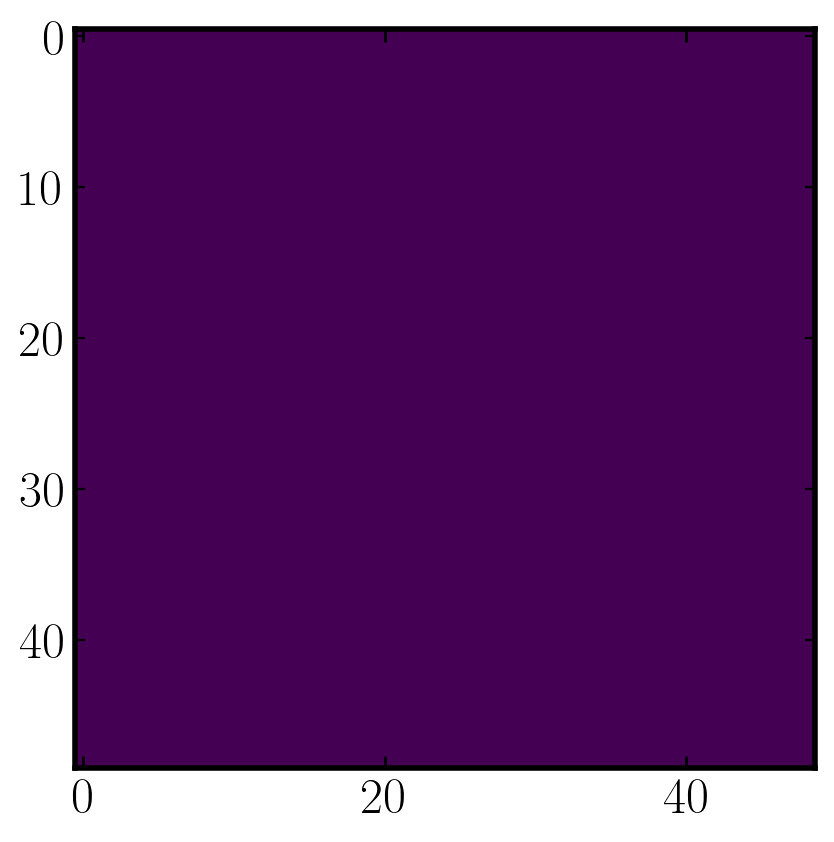

In [25]:
plt.imshow(noise_corr)

In [27]:
noise_corr.max()

0.0